In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime as dt
from sklearn.decomposition import PCA
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
import pymc3 as pm
import theano
from scipy import optimize
from copy import deepcopy
import seaborn as sns

In [26]:
class DataFetcher:
    def __init__(self, url="https://api.covid19india.org/data.json"):
        self.url = url
        self.json_data = None
        self.cases_time_series = None
        
    def fetch(self):
        r = requests.get(url=self.url)
        self.json_data = r.json()
        
        # NOTE : start date of this data is 30 Jan
        
        # Get the fields
        fields = list(self.json_data['cases_time_series'][0].keys())
        self.cases_time_series = {}
        
        for field in fields:
            if field == 'date':
                self.cases_time_series[field] = [x[field] for x in self.json_data['cases_time_series']]
            else:
                self.cases_time_series[field] = np.array([float(x[field]) for x in self.json_data['cases_time_series']])

In [27]:
class DataFetcherState:
    """Fetch data for all states"""
    
    def __init__(self):
        self.data = None
        self.raw_data = None
    
    def fetch(self):
        # Fetch the raw data
        r = requests.get(url="https://api.covid19india.org/states_daily.json")
        self.raw_data = r.json()
        self.data = {}
        
        # Iterate over the days and record the data
        for entry in self.raw_data['states_daily']:
            status = entry['status'].lower()
            for state in entry:
                if state == "date" or state == "status":
                    continue
                    
                if state not in self.data:
                    # Initialize this state
                    self.data[state] = {
                        'deceased': [],
                        'recovered': [],
                        'confirmed': []
                    }
                
                # Append the data
                self.data[state][status].append(entry[state])
                
    def start_date(self):
        return self.raw_data['states_daily'][0]['date']

In [28]:
def get_mob_data(region=None):
    df = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
    df = df[df['country_region'] == 'India']
    if region is None:
        df = df[pd.isnull(df['sub_region_1'])]
    else:
        df = df[df['sub_region_1'] == region]
    df = df[df['date'] >= '2020-02-25']
    
    return df

In [29]:
def get_social_distance(df, death_data):
    """Retrieve social distancing data from dataframe and return the pcas"""

    df = deepcopy(df)
    
    
    locations = ['retail_and_recreation',
                 'grocery_and_pharmacy',
                 'parks',
                 'transit_stations',
                 'workplaces',
                 'residential']
    
    # Make the lengths of the data equal
    if len(df) > len(death_data):
        df = df[:-(len(df) - len(death_data))]
    else:
        for i in range(len(death_data) - len(df)):
            df = df.append(df.iloc[-1])

    X = np.zeros((len(df), len(locations)))
            
    for i, loc in enumerate(locations):
        X[:, i] += np.array(df['{}_percent_change_from_baseline'.format(loc)])
    
    return PCA(n_components=4).fit_transform(X)

<h1>India - with social distancing </h1>

The model has the following specification

$$y_{it} \sim \textrm{NegBin}(\lambda_{it}, r)$$

$$log \lambda_{it} = \beta_{it,0} + \beta_{it,1}t + \beta_{it,2}t^2$$

$$(\beta_{it,0}, \beta_{it,1}, \beta_{it,2})^T = \mu + \Gamma x_{it} + \eta_i$$

$$\eta_i \sim \mathcal{N}(0, \Sigma)$$

Here, the parameters are $\mu \in \mathbb{R}^{3\times1}, \Gamma \in \mathbb{R}^{3\times4}, \Sigma \in \mathbb{R}^{3\times3}$

In [30]:
# Get data for India
offset = 43
df = get_mob_data()
fetcher = DataFetcher()
fetcher.fetch()
death_data = fetcher.cases_time_series['dailydeceased'][offset:]

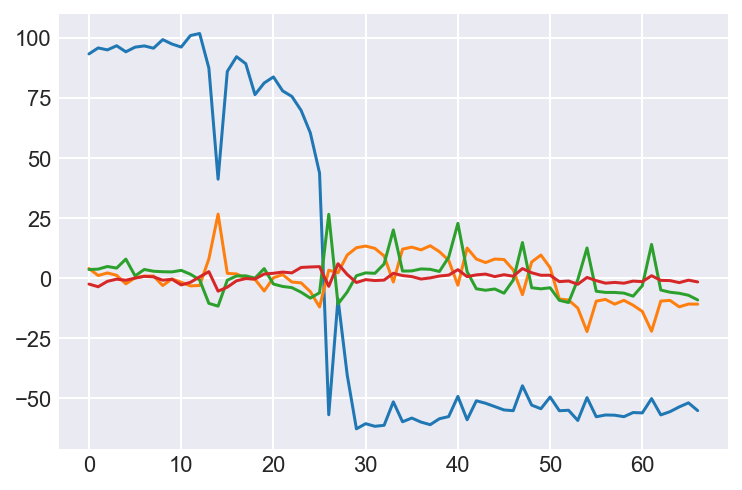

In [31]:
# Plot the PCs
social_distance = get_social_distance(df, death_data)

# Plot the PCAs
for x in social_distance.T:
    plt.plot(x)
    
plt.show()

In [ ]:
###########
# Look at this tutorial -
# https://docs.pymc.io/notebooks/getting_started.html
###########    
 
model = pm.Model()
n_data = social_distance.shape[0]
t = np.arange(n_data)


with model:
#     Weakly informative priors on the parameters
    gamma = pm.Normal('gamma', mu=0, sigma=10, shape=(4, 3))
    mu = pm.Normal('mu', mu=1e-3, sigma=10, shape=3)
#     gamma = pm.Uniform('gamma', lower=-200, upper=200, shape=(4, 3))
#     mu = pm.Uniform('mu', lower=-200, upper=200, shape=3)
    
    sd_dist = pm.HalfCauchy.dist(beta=2.5)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=3, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(3, packed_chol, lower=True)
    
    # Define relationships amongst the params
    eta = pm.MvNormal('eta', mu=np.ones(3) * 1e-3, cov=chol, shape=3)
    
    mat = social_distance @ gamma
    
    beta_0 = mu[0] + mat[:, 0] + eta[0]
    beta_1 = mu[1] + mat[:, 1] + eta[1]
    beta_2 = mu[2] + mat[:, 2] + eta[2]
    
    lamb = np.exp(beta_0 + beta_1 * t + beta_2 * (t ** 2))
    
    Y_obs = pm.NegativeBinomial('Y_obs', mu=lamb, alpha=1, observed=death_data)
    
#     for RV in model.basic_RVs:
#         print(RV.name, RV.logp(model.test_point))
    
    # obtain starting values via MAP
#     start = pm.find_MAP(fmin=optimize.fmin_powell)
    
    # instantiate sampler
#     step = pm.NUTS(scaling=start)
    
    # draw 2000 posterior samples
    trace = pm.sample(step=pm.NUTS(), init='advi+adapt_diag')
#     map_estimate = pm.find_MAP(model=model)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eta, chol_cov, mu, gamma]
Sampling 2 chains, 0 divergences:  30%|███       | 604/2000 [02:11<09:35,  2.42draws/s]

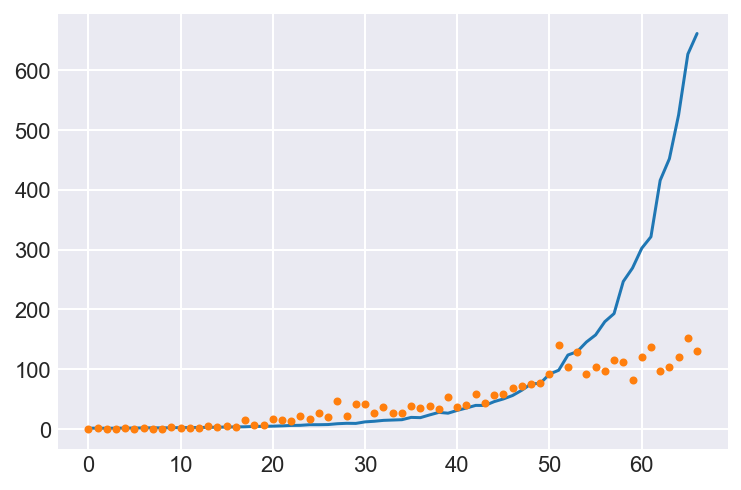

In [55]:
plt.plot(post_pred['Y_obs'].mean(axis=0))
plt.plot(death_data, '.')
plt.show()